In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from functools import partial

from theano import shared, function, scan
import theano.tensor as tt
from theano.tensor import slinalg
from theano.tensor.nlinalg import matrix_inverse
cholesky = slinalg.cholesky

from pymc3 import Model, sample, Metropolis, advi, Deterministic, Mixture, generator
from pymc3 import DensityDist, CategoricalGibbsMetropolis, Minibatch, logsumexp
from pymc3.distributions import *
from pymc3.gp import cov, gp, mean
from pymc3 import ADVI, adam, fit, SVGD, sample_ppc, sgd
from pymc3 import forestplot, traceplot

DATA_DIR = '../data/clean/'

Sample of 5000 patients

In [2]:
bmi_by_patient = (pd.read_csv(DATA_DIR+'bmi_by_patient.csv', index_col=0)
                      .dropna(axis=1, thresh=5))
bmi_by_patient.head()

,1621101,1685338,1713205,1958537,2025534,2062537,2087799,2129427,2186450,2382232,...,40985475,41005570,41014622,41014655,41043167,41052325,41054388,41077231,41087032,41248451
Days,,,,,,,,,,,,,,,,,,,,,
0,27.464844,NaN,29.679341,27.51063,27.032689,27.484552,29.380994,27.614212,29.743767,28.201669,...,27.777479,29.785761,28.921647,NaN,28.096818,28.663549,27.26058,27.125971,27.423469,28.801188
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.785761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.695456
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.969401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.209745
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29.030746,NaN,NaN,NaN,NaN,NaN,NaN,28.695456
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
assert bmi_by_patient.notnull().sum().min() == 5

In [4]:
bmi_by_patient.index =  pd.to_datetime(bmi_by_patient.index, unit='D')

In [5]:
bmi_resampled = bmi_by_patient.resample('2W').mean()
bmi_resampled.shape

(27, 5915)

In [6]:
# data_subset = bmi_resampled.iloc[:, :500]
data_subset = bmi_resampled.copy()

Random sample of 100 trajectories

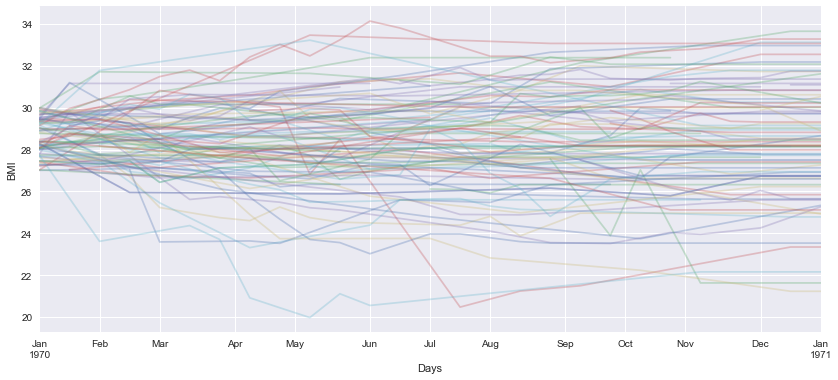

In [7]:
fig, axes = plt.subplots(figsize=(14,6))
(bmi_resampled[np.random.choice(bmi_resampled.columns, 100)].interpolate(limit=10)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('BMI');

In [8]:
data_subset.shape

(27, 5915)

Stick-breaking function for Dirichlet process

In [9]:
def stick_breaking(beta):
    
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

Maximum number of groups

In [10]:
CLUSTERS = 20
D, N = data_subset.shape

In [11]:
data_missing = np.ma.masked_equal(data_subset.fillna(42).values, 42).T

In [12]:
data_missing.shape

(5915, 27)

In [13]:
APPROX = True

if APPROX:
    BATCH_SIZE = 10
    minibatches = Minibatch(data_missing, batch_size=BATCH_SIZE)
else:
    BATCH_SIZE = N
    minibatches = data_missing

X = np.arange(D).reshape(-1, 1)

In [15]:
with Model() as model:
        
    # DP concentration parameter
    α = Gamma('α', 1., 1.)
    # Stick-breaking components
    β = Beta('β', 1., 1, shape=CLUSTERS)
    ω = Deterministic('ω', stick_breaking(β))
    
    # Hyperparameters of GPs
    η = HalfCauchy('η', 3, shape=CLUSTERS)
    ρ = HalfCauchy('ρ', 3, shape=CLUSTERS)
    # Noise
    σ = HalfCauchy('σ', 5)
    
    # Covariance functions for each component
    K = [(η[c]**2)*cov.Matern32(1, ρ[c]**2) for c in range(CLUSTERS)]
    
    def calc_logp(y, s):
            return tt.stack([MvNormal.dist(tt.zeros_like(y), 
                                            chol=cholesky(k(X) + s)).logp(y) for k in K])
    
    def logp(value):
        
        s = tt.eye(D)*(σ**2)
        
        # Mixture of Gaussian processes
        gp_logp, _ = scan(calc_logp, sequences=[value], non_sequences=[s])
        
        return tt.sum(logsumexp(tt.log(ω) + gp_logp, axis=-1))
        
    trajectories = DensityDist('trajectories', logp, observed=minibatches, 
                               shape=(BATCH_SIZE, D), total_size=data_missing.shape)
        

In [ ]:
with model:
    
    # Prediction over grid
    xgrid = np.linspace(0, 25)
    D_pred = squared_distance(xgrid, xgrid)
    D_off_diag = squared_distance(x, xgrid)
    
    # Covariance matrices for prediction
    Σ_pred = η_sq * T.exp(-ρ_sq * D_pred)
    Σ_off_diag = η_sq * T.exp(-ρ_sq * D_off_diag)
    
    # Posterior mean
    μ_post = Deterministic('μ_post', T.dot(T.dot(Σ_off_diag, matrix_inverse(Σ)), y))
    # Posterior covariance
    Σ_post = Deterministic('Σ_post', Σ_pred - T.dot(T.dot(Σ_off_diag, matrix_inverse(Σ)), Σ_off_diag.T))

In [19]:
with model:
    if APPROX:
        approx = fit(n=30000, method='fullrank_advi')
        trace = approx.sample(1000)
    else:
        trace = sample(1000, n_init=50000, burn=2000)

KeyboardInterrupt: 

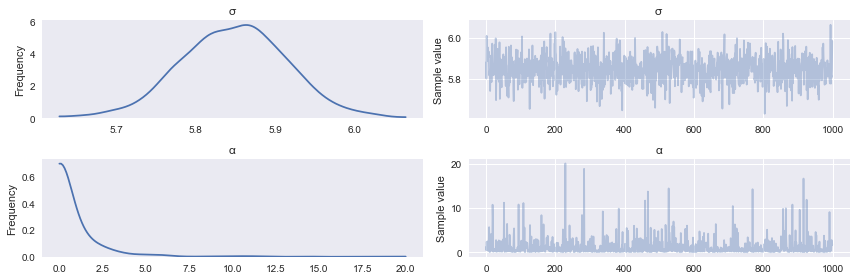

In [64]:
traceplot(trace, varnames=['σ', 'α']);

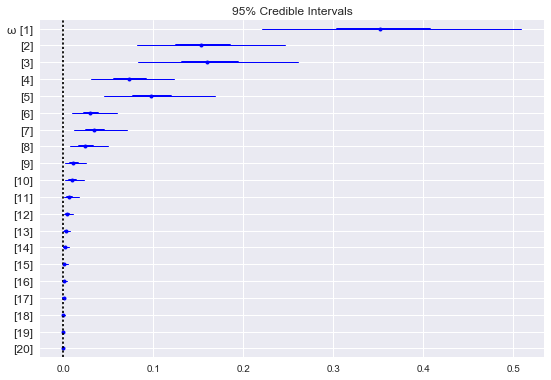

In [28]:
forestplot(trace, varnames=['ω'])

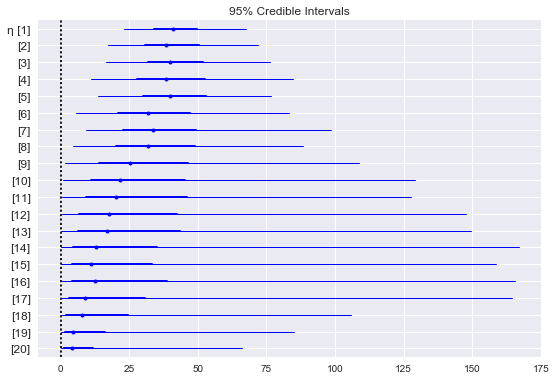

In [29]:
forestplot(trace, varnames=['η'])

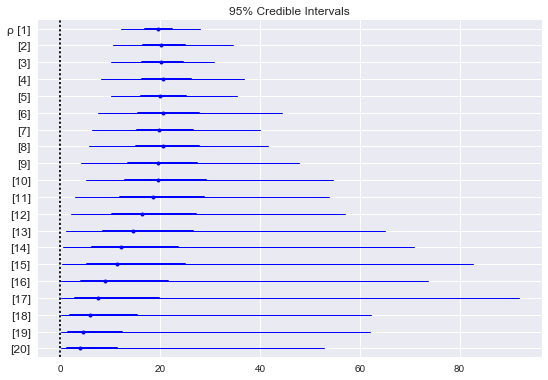

In [30]:
forestplot(trace, varnames=['ρ'])

In [48]:
with model:
    posterior_samples = sample_ppc(trace, 100, vars=[η, ρ, σ])

100%|██████████| 100/100 [00:00<00:00, 147.98it/s]


In [49]:
eta = posterior_samples['η']
sigma = posterior_samples['σ']
rho = posterior_samples['ρ']